In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import os
import glob
import time
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import pathlib

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
device

device(type='cuda')

In [46]:
transformer = transforms.Compose([
     transforms.Resize((128, 128)),
     #transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize([0.5, 0.5, 0.5],
                          [0.5, 0.5, 0.5])
])

In [47]:
train_path='/content/drive/My Drive/real_and_fake_face'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)

In [48]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['training_fake', 'training_real']


## **CNN**

In [49]:
class network(nn.Module):
    def __init__(self):
        super(network,self).__init__()
        self.keep = 0.5

        self.conv1=nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=8)
        self.relu1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(num_features=16)
        self.relu2=nn.ReLU()

        self.conv3=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()

        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.conv4=nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.bn4=nn.BatchNorm2d(num_features=16)
        self.relu4=nn.ReLU()
        

        self.flatten = nn.Flatten()

        self.fc=nn.Linear(in_features=33*33*16,out_features=625, bias=True)
        self.relu5=nn.ReLU()
        self.dout=nn.Dropout(p=1 - self.keep)

        self.outputs = torch.nn.Linear(625, 2, bias=True)
        
                
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool1(output)
            
        output=self.conv2(output)
        output=self.bn2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)

        output=self.pool2(output)

        output=self.conv4(output)
        output=self.bn4(output)
        output=self.relu4(output)

        output=self.flatten(output)
                        
        #output=output.view(-1,32*75*75)
        output=self.fc(output)


        output=self.relu5(output)
        output=self.dout(output)
            
            
        #output=self.fc(output)
        output=self.outputs(output) 

        return output


In [50]:
model=network().to(device)

In [51]:
optimizer=Adam(model.parameters(),lr=1e-3,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [56]:
num_epochs=30

In [57]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
print(train_count)

2041


In [58]:
best_accuracy=0.0

loss_val = []
accurecy_val = []

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    loss_val.append(train_loss)
    accurecy_val.append(train_accuracy)
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy))
    
    #Save the best model
    if train_accuracy>best_accuracy:
        torch.save(model,'/content/drive/My Drive/Models/my_best_model.model')
        torch.save(model,'/content/drive/My Drive/Models/my_best_model.pth')
        best_accuracy=train_accuracy

Epoch: 0 Train Loss: tensor(0.2225) Train Accuracy: 0.9152376286134248
Epoch: 1 Train Loss: tensor(0.1751) Train Accuracy: 0.9416952474277315
Epoch: 2 Train Loss: tensor(0.1209) Train Accuracy: 0.9583537481626654
Epoch: 3 Train Loss: tensor(0.0947) Train Accuracy: 0.9671729544341009
Epoch: 4 Train Loss: tensor(0.0945) Train Accuracy: 0.9706026457618814
Epoch: 5 Train Loss: tensor(0.0768) Train Accuracy: 0.9804017638412543
Epoch: 6 Train Loss: tensor(0.0803) Train Accuracy: 0.9764821166095051
Epoch: 7 Train Loss: tensor(0.0631) Train Accuracy: 0.9813816756491915
Epoch: 8 Train Loss: tensor(0.0502) Train Accuracy: 0.986281234688878
Epoch: 9 Train Loss: tensor(0.0381) Train Accuracy: 0.9897109260166586
Epoch: 10 Train Loss: tensor(0.0362) Train Accuracy: 0.9902008819206272
Epoch: 11 Train Loss: tensor(0.0456) Train Accuracy: 0.9867711905928467
Epoch: 12 Train Loss: tensor(0.0620) Train Accuracy: 0.9808917197452229
Epoch: 13 Train Loss: tensor(0.0517) Train Accuracy: 0.9833414992650662
Epo

Text(0.5, 1.0, 'Accuracy')

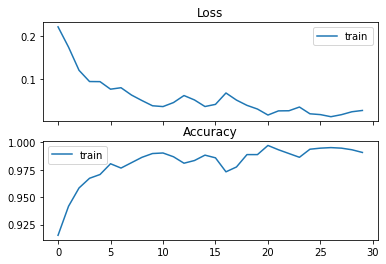

In [59]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(loss_val)
ax1.legend(['train'])
ax1.set_title('Loss')

ax2.plot(accurecy_val)
ax2.legend(['train'])
ax2.set_title('Accuracy')